# 1. Data describe

In [1]:
import pandas as pd
from pyproj import CRS
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

CRS_4326 = CRS('epsg:4326')

data_path = 'sun_power_dataset.csv'

# location_list = ['Camp Murray' 'Grissom' 'Hill Weber' 'JDMT' 'Kahului' 'Malmstrom'
#                  'March AFB' 'MNANG' 'Offutt' 'Peterson' 'Travis' 'USAFA']

sun_data_df = pd.read_csv(data_path, keep_default_na=False)

sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'], format="%Y%m%d")
sun_data_df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,Month,Hour,Season,Humidity,Temp,Wind,Visibility,Pressure,Cloud,PolyPwr
0,Camp Murray,2017-12-03,1145,47.11,-122.57,84,12,11,Winter,81.71997,12.86919,5,10.0,1010.6,722,2.42769
1,Camp Murray,2017-12-03,1315,47.11,-122.57,84,12,13,Winter,96.64917,9.66415,0,10.0,1011.3,23,2.46273
2,Camp Murray,2017-12-03,1330,47.11,-122.57,84,12,13,Winter,93.61572,15.44983,5,10.0,1011.6,32,4.46836
3,Camp Murray,2017-12-04,1230,47.11,-122.57,84,12,12,Winter,77.21558,10.36659,5,2.0,1024.4,6,1.65364
4,Camp Murray,2017-12-04,1415,47.11,-122.57,84,12,14,Winter,54.80347,16.85471,3,3.0,1023.7,9,6.57939


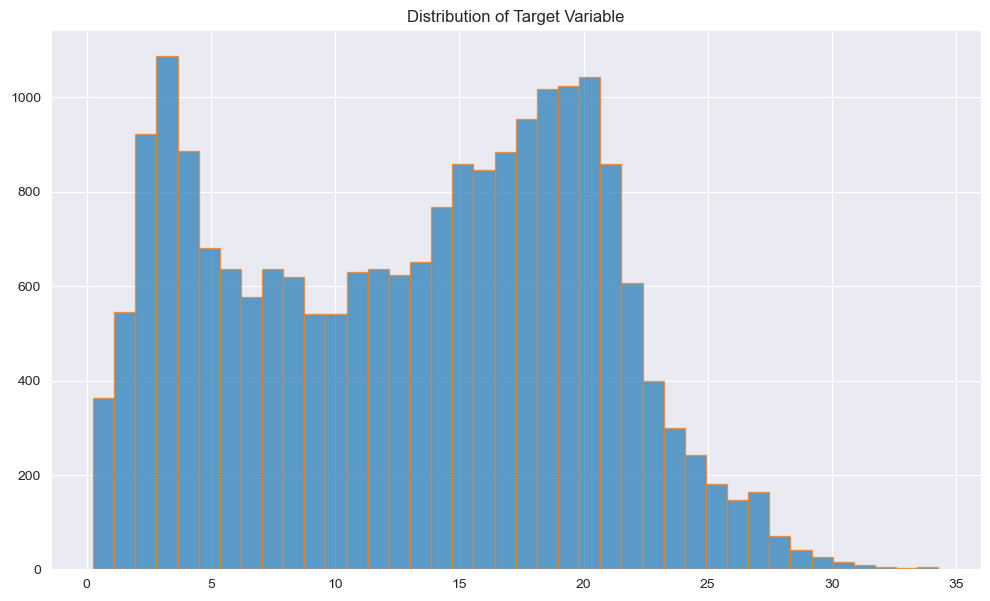

In [2]:
# 检查目标变量的分布
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
ax.set_title('Distribution of Target Variable')
ax.hist(sun_data_df['PolyPwr'], bins=40, density=False, facecolor="tab:blue", edgecolor="tab:orange", alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Visualize missing values in datasets')

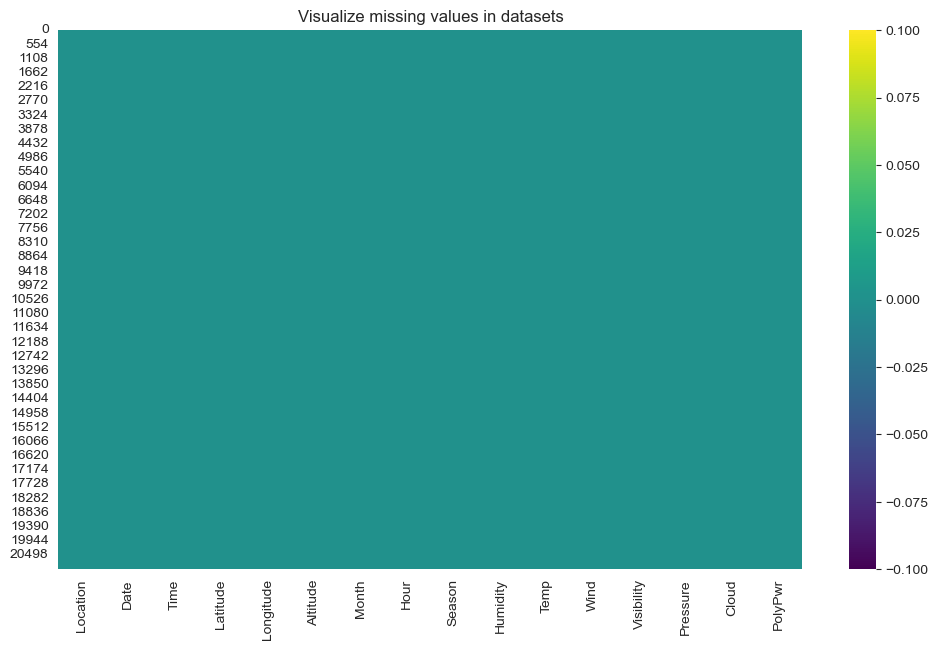

In [3]:
import seaborn as sns

# plot is null
plt.figure(figsize=(12, 7))
sns.heatmap(sun_data_df.isnull(), cmap='viridis')
plt.title('Visualize missing values in datasets')

# 2. Data process

In [4]:
# classify power class

class_arr = []
for i in sun_data_df['PolyPwr']:
    if i < 8:
        class_arr.append(1)
    elif i < 12:
        class_arr.append(2)
    elif i < 16:
        class_arr.append(3)
    elif i < 20:
        class_arr.append(4)
    elif i < 24:
        class_arr.append(5)
    else:
        class_arr.append(6)
sun_data_df['power_class'] = pd.Series(class_arr)

sun_data_df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,Month,Hour,Season,Humidity,Temp,Wind,Visibility,Pressure,Cloud,PolyPwr,power_class
0,Camp Murray,2017-12-03,1145,47.11,-122.57,84,12,11,Winter,81.71997,12.86919,5,10.0,1010.6,722,2.42769,1
1,Camp Murray,2017-12-03,1315,47.11,-122.57,84,12,13,Winter,96.64917,9.66415,0,10.0,1011.3,23,2.46273,1
2,Camp Murray,2017-12-03,1330,47.11,-122.57,84,12,13,Winter,93.61572,15.44983,5,10.0,1011.6,32,4.46836,1
3,Camp Murray,2017-12-04,1230,47.11,-122.57,84,12,12,Winter,77.21558,10.36659,5,2.0,1024.4,6,1.65364,1
4,Camp Murray,2017-12-04,1415,47.11,-122.57,84,12,14,Winter,54.80347,16.85471,3,3.0,1023.7,9,6.57939,1


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def get_data_split(data_df, selected_columns, target_label):
    df_processed = data_df[selected_columns].reset_index(drop=True)
    input_feat = list(set(selected_columns).difference({target_label}))

    df_x = df_processed[input_feat].reset_index(drop=True)
    df_y = df_processed[target_label]

    transfer = MinMaxScaler(feature_range=(0, 1))

    # normalization
    df_x = transfer.fit_transform(df_x)

    return train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [7]:
# # Get spilt data but without feature engineering
#
# df_with_location_en = pd.get_dummies(sun_data_df, columns=['Location'], drop_first=True)
# df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)
#
# selected_columns = ['Latitude', 'Longitude', 'Altitude',
#                     'Month', 'Hour', 'Humidity', 'Temp',
#                     'Wind', 'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
#                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
#                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
#                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
#                     'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'power_class']
#
# x_train, x_test, y_train, y_test = get_data_split(df_with_loc_season_en, selected_columns, 'power_class')
#
# print(len(x_train), len(x_test))

16836 4209


In [98]:
# 热编码方法对分类变量即位置和季节进行编码
df_with_location_en = pd.get_dummies(sun_data_df, columns=['Location'], drop_first=True)
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

# 使用月份和小时数据创建循环特征。
# 只有上午10点到下午3点之间的数据可用，排除不会发电的时间段。
# 定义时间范围
min_hour_of_interest = 10
max_hour_of_interest = 15

# 计算自发电开始以来的时间差
df_with_loc_season_en['delta_hr'] = df_with_loc_season_en.Hour - min_hour_of_interest

# 日期特征的余弦与其实际值（月份和小时）之间存在完美的相关性。
# 因此使用其三角函数值代替其特征。
# 计算循环月特征
df_with_loc_season_en['sine_mon'] = np.sin((df_with_loc_season_en.Month - 1) * np.pi / 11)
df_with_loc_season_en['cos_mon'] = np.cos((df_with_loc_season_en.Month - 1) * np.pi / 11)
# 计算循环小时特征
df_with_loc_season_en['sine_hr'] = np.sin(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr'] = np.cos(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))

selected_columns = ['Latitude', 'Humidity', 'Temp', 'power_class', 'Wind',
                    'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
                    'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                    'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                    'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                    'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                    'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

x_train, x_test, y_train, y_test = get_data_split(df_with_loc_season_en, selected_columns, 'power_class')

print(len(x_train), len(x_test))

16836 4209


# 3. Model
## a. Decision Tree

In [107]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dt = DecisionTreeClassifier(random_state=24)
dt = dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))

# 在不进行调参的情况下，明显是一个过拟合的模型，在训练集上的表现明显优于测试集上的表现

accuracy: 0.5559515324305061
train f1_score: 1.0
test f1_score: 0.5546640467492485


In [108]:
# 调整树的深度有助于防止过拟合

dt = DecisionTreeClassifier(max_depth=3, random_state=24)
dt = dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))



accuracy: 0.4492753623188406
train f1_score: 0.538967137808641
test f1_score: 0.5518539105321666


Text(0.5, 1.0, 'Scores at different depths')

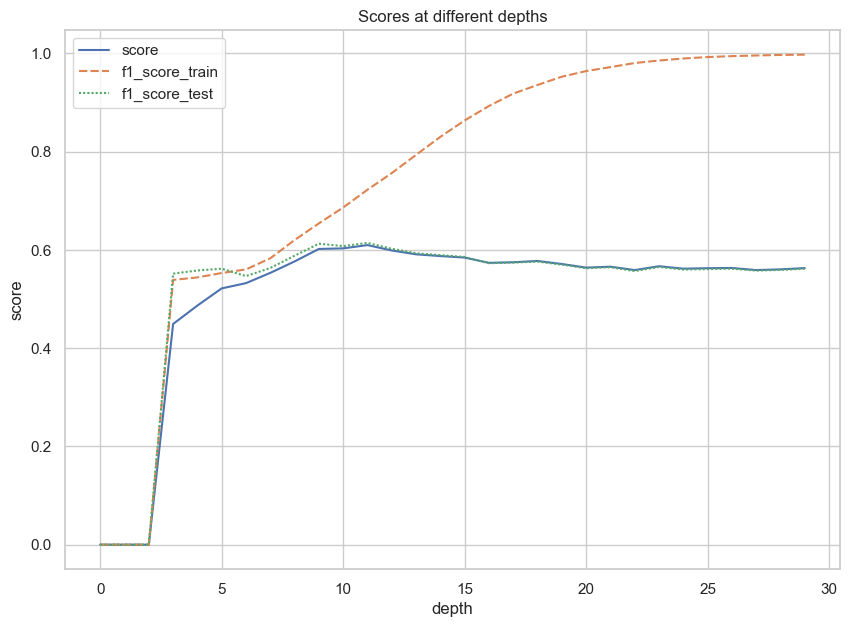

In [110]:
depths = range(3, 30)
score = np.zeros(30)
f1_score_train = np.zeros(30)
f1_score_test = np.zeros(30)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=24)
    dt.fit(x_train, y_train)
    score[depth] = dt.score(x_test, y_test)
    f1_score_train[depth] = metrics.f1_score(dt.predict(x_train), y_train, average='weighted')
    f1_score_test[depth] = metrics.f1_score(dt.predict(x_test), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test})
sns.lineplot(data=data)
plt.xlabel("depth")
plt.ylabel("score")
plt.title("Scores at different depths")

In [111]:
# 从上图可以清楚看到随着树的深度的增加，测试集上与训练集上的表现差距越来越大
# 综合考虑三个指标，认为取max_depth=6是比较合适的一个数值

dt = DecisionTreeClassifier(max_depth=6, random_state=24)
dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))


accuracy: 0.5324305060584462
train f1_score: 0.5603333508874698
test f1_score: 0.5468113588011567


Text(0.5, 1.0, 'scores at different min_weight_fraction_leaf')

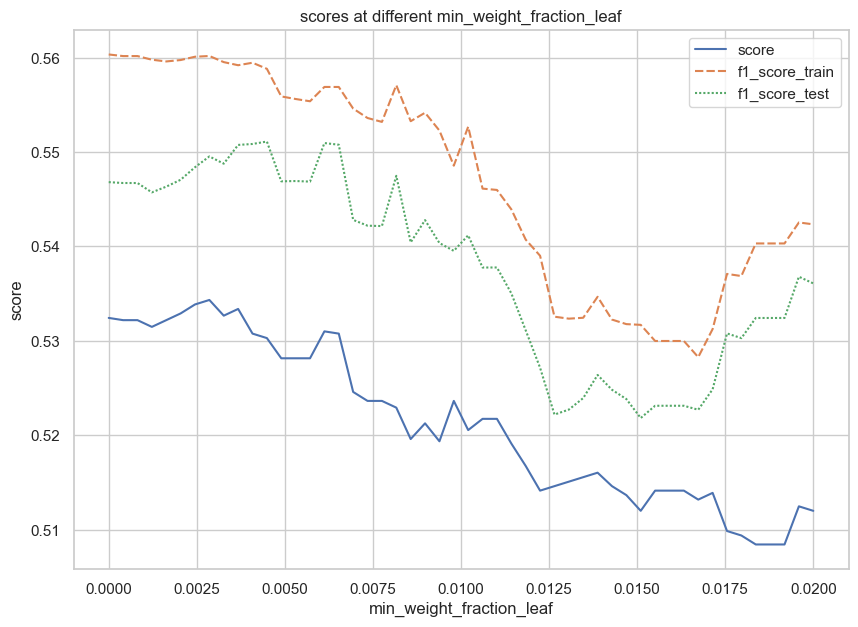

In [112]:
# 探究min_weight_fraction_leaf参数

min_weight_fraction = np.linspace(0, 0.02, 50, endpoint=True)
fraction_score = np.zeros(50)
f1_score_test = np.zeros(50)
f1_score_train = np.zeros(50)
i = 0
for min_weight in min_weight_fraction:
    dt = DecisionTreeClassifier(max_depth=6, min_weight_fraction_leaf=min_weight, random_state=24)
    dt.fit(x_train, y_train)

    fraction_score[i] = dt.score(x_test, y_test)
    f1_score_train[i] = metrics.f1_score(dt.predict(x_train), y_train, average='weighted')
    f1_score_test[i] = metrics.f1_score(dt.predict(x_test), y_test, average='weighted')
    i = i + 1

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": fraction_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=min_weight_fraction)
sns.lineplot(data=data)
plt.xlabel("min_weight_fraction_leaf")
plt.ylabel("score")
plt.title("scores at different min_weight_fraction_leaf")

# 可以看到还是将这个权重设为0比较好，默认值也是0

Text(0.5, 1.0, 'scores at different n_components')

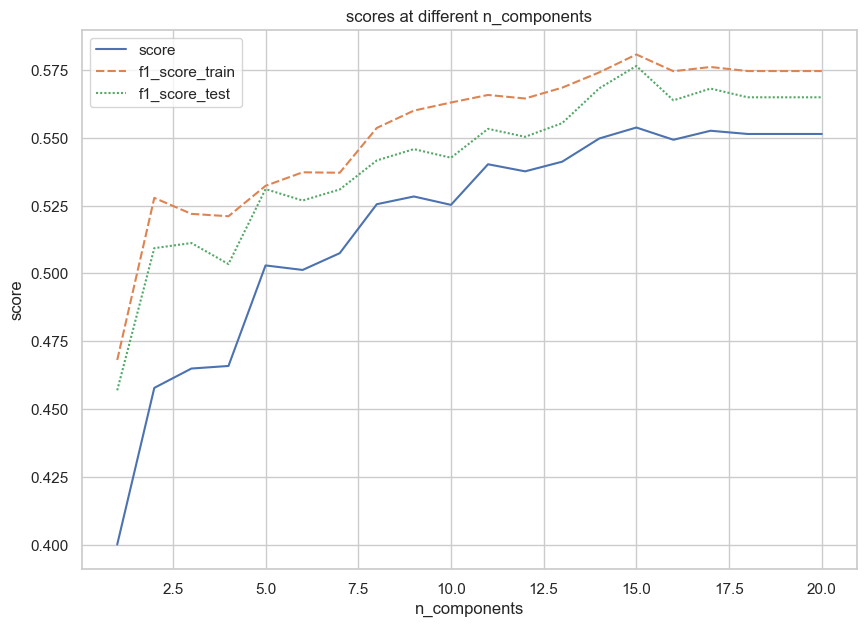

In [137]:
from sklearn.decomposition import PCA

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    dt = DecisionTreeClassifier(max_depth=6, random_state=24)
    dt.fit(x_train_pca, y_train)

    pca_score[j] = dt.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(dt.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(dt.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [115]:
# 可以看到选择n_components=15左右比较合适

pca = PCA(n_components=15, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
dt = DecisionTreeClassifier(max_depth=6, random_state=24)
dt.fit(x_train_pca, y_train)

print("accuracy:", dt.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test_pca), y_test, average='weighted'))

accuracy: 0.5538132573057734
train f1_score: 0.5807479772371719
test f1_score: 0.5765097184159866


## b. KNN

In [106]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn = knn.fit(x_train, y_train)

print("accuracy:", knn.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(knn.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(knn.predict(x_test), y_test, average='weighted'))

accuracy: 0.619624613922547
train f1_score: 0.7255818149767089
test f1_score: 0.6258198429578653


In [120]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"],
               'n_neighbors': range(1, 11),
               'metric': ['euclidean', 'manhattan', 'cosine']}]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=2, we

In [134]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights="uniform")
knn = knn.fit(x_train, y_train)

print("accuracy:", knn.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(knn.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(knn.predict(x_test), y_test, average='weighted'))

KNeighborsClassifier(metric='manhattan', n_neighbors=10)
accuracy: 0.6379187455452602
train f1_score: 0.6925035472375817
test f1_score: 0.6462416728428185


Text(0.5, 1.0, 'scores at different n_components')

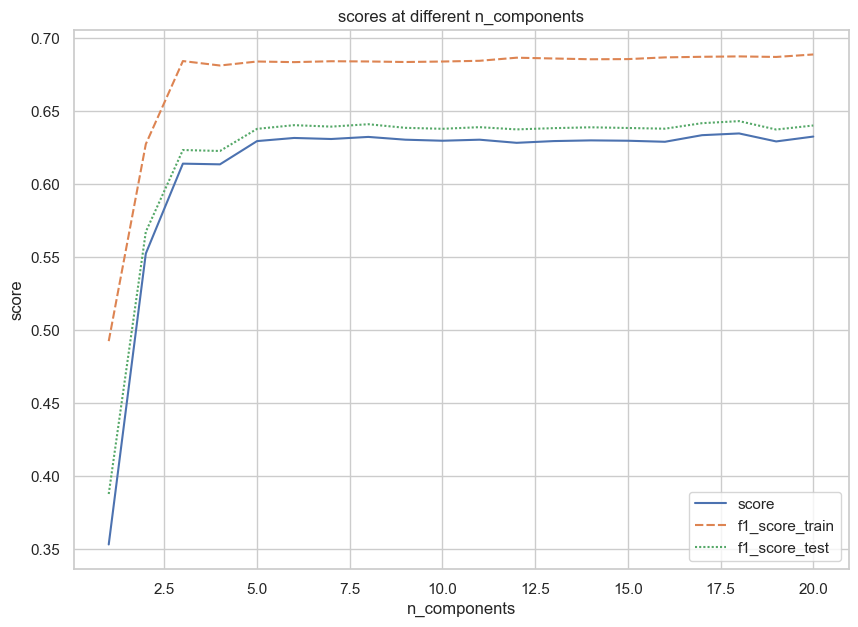

In [135]:
from sklearn.decomposition import PCA

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights="uniform")
    knn.fit(x_train_pca, y_train)

    pca_score[j] = knn.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(knn.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(knn.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [138]:
# knn的PCA中n_components=5左右比较合适

pca = PCA(n_components=5, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

knn = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights="uniform")
knn.fit(x_train_pca, y_train)

print("accuracy:", knn.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(knn.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(knn.predict(x_test_pca), y_test, average='weighted'))

# 此时虽然精度略低于上面的结果 但是仅用到5个pca后的变量即可达到该效果

accuracy: 0.6293656450463293
train f1_score: 0.6838258666280942
test f1_score: 0.6377397512965627


## c. Naive Bayes

In [156]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

print("accuracy:", gnb.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(gnb.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(gnb.predict(x_test), y_test, average='weighted'))

accuracy: 0.4378712283202661
train f1_score: 0.45986367318141497
test f1_score: 0.45190464742593156


Text(0.5, 1.0, 'scores at different n_components')

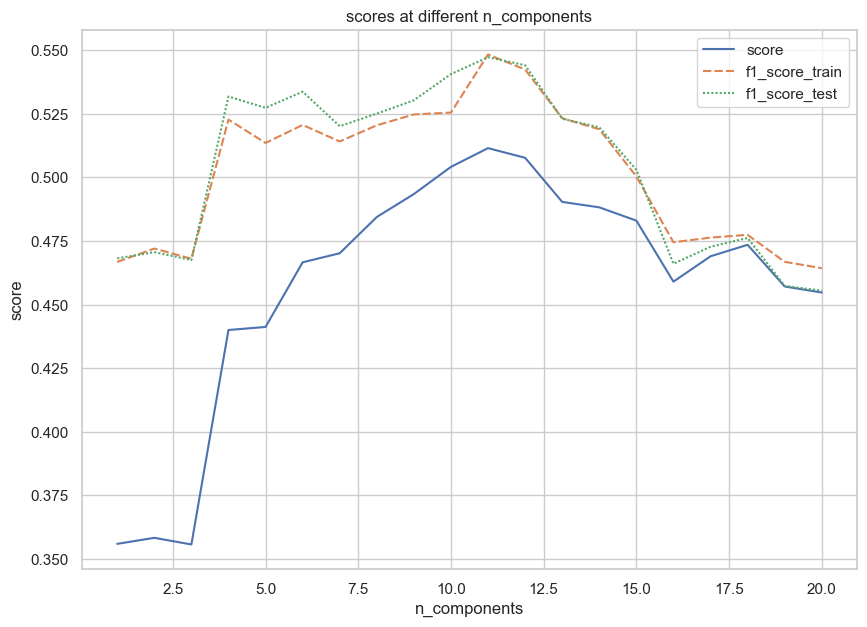

In [158]:
from sklearn.decomposition import PCA

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    gnb = GaussianNB()
    gnb.fit(x_train_pca, y_train)

    pca_score[j] = gnb.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(gnb.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(gnb.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [159]:
# pca 11

pca = PCA(n_components=11, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

gnb = GaussianNB()
gnb.fit(x_train_pca, y_train)

print("accuracy:", gnb.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(gnb.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(gnb.predict(x_test_pca), y_test, average='weighted'))

accuracy: 0.5115229270610596
train f1_score: 0.5483553920490281
test f1_score: 0.5472818474887481


## d. Neural Network

In [142]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=24)
mlp.fit(x_train, y_train)

print("accuracy:", mlp.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(mlp.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(mlp.predict(x_test), y_test, average='weighted'))

accuracy: 0.641720123544785
train f1_score: 0.6748130258030048
test f1_score: 0.6513215545650864


In [144]:
mlp_clf__tuned_parameters = {
    "activation": ['identity', 'logistic', 'tanh', 'relu'],
    "solver": ['adam', 'sgd', 'lbfgs'],
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "max_iter": [20]
}
mlp = MLPClassifier(random_state=24)
estimator = GridSearchCV(mlp, mlp_clf__tuned_parameters, n_jobs=6)
estimator.fit(x_train, y_train)

print(estimator.get_params().keys())
print(estimator.best_params_)

/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


dict_keys(['cv', 'error_score', 'estimator__activation', 'estimator__alpha', 'estimator__batch_size', 'estimator__beta_1', 'estimator__beta_2', 'estimator__early_stopping', 'estimator__epsilon', 'estimator__hidden_layer_sizes', 'estimator__learning_rate', 'estimator__learning_rate_init', 'estimator__max_fun', 'estimator__max_iter', 'estimator__momentum', 'estimator__n_iter_no_change', 'estimator__nesterovs_momentum', 'estimator__power_t', 'estimator__random_state', 'estimator__shuffle', 'estimator__solver', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
{'activation': 'relu', 'hidden_layer_sizes': (100, 30), 'learning_rate': 'adaptive', 'max_iter': 20, 'solver': 'adam'}


In [148]:
mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 30), learning_rate='adaptive', max_iter=20,
                    solver='adam')
mlp.fit(x_train, y_train)

print("accuracy:", mlp.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(mlp.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(mlp.predict(x_test), y_test, average='weighted'))

accuracy: 0.6296032311712996
train f1_score: 0.6558986341331347
test f1_score: 0.6498888962336364


Text(0.5, 1.0, 'scores at different n_components')

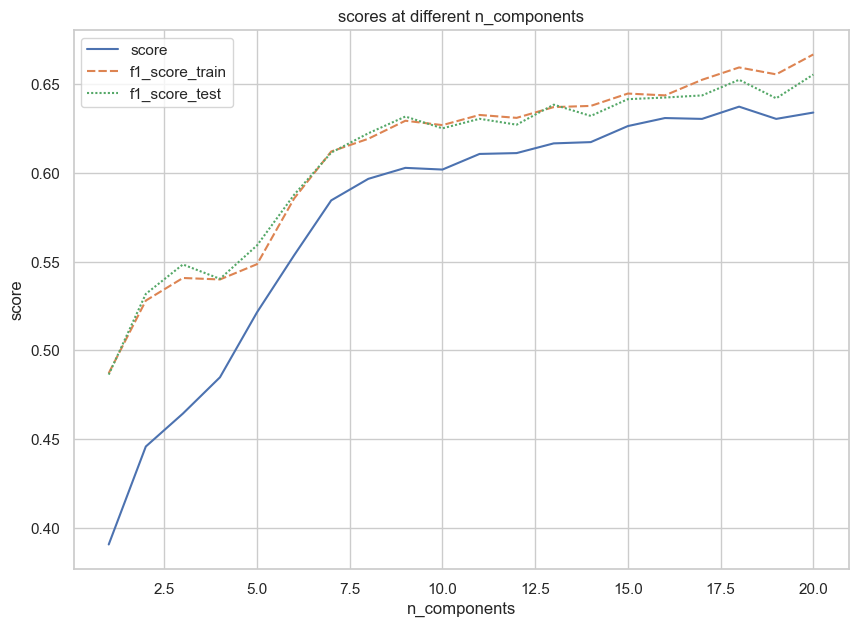

In [149]:
from sklearn.decomposition import PCA

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 30), learning_rate='adaptive', max_iter=20,
                        solver='adam')
    mlp.fit(x_train_pca, y_train)

    pca_score[j] = mlp.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(mlp.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(mlp.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [151]:
# pca 16

pca = PCA(n_components=16, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 30), learning_rate='adaptive', max_iter=20,
                    solver='adam')
mlp.fit(x_train_pca, y_train)

print("accuracy:", mlp.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(mlp.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(mlp.predict(x_test_pca), y_test, average='weighted'))

accuracy: 0.6224756474221905
train f1_score: 0.6471076384309079
test f1_score: 0.6436739498415976


## e. Ensemble

In [165]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


def assemble(x_train, y_train, x_test, y_test):
    abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=200)
    abc.fit(x_train, y_train)

    print(abc.__class__.__name__, '(DecisionStumps)')
    y_pred = abc.predict(x_train)
    print('\ttrain:', accuracy_score(y_train, y_pred))
    y_pred = abc.predict(x_test)
    print('\ttest:', accuracy_score(y_test, y_pred))


# assemble(x_train, y_train, x_test, y_test)

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=200)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.43145640294606796
train f1_score: 0.48558975030493806
test f1_score: 0.4294780577946569


In [164]:
estimatorCart = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=24)

# 第一轮
# 对框架参数 弱学习器个数进行择优
param_test1 = {"n_estimators": range(150, 300, 50)}
# 框架参数择优
gsearch1 = GridSearchCV(estimator=AdaBoostClassifier(estimatorCart), param_grid=param_test1, scoring="roc_auc", cv=5)
gsearch1.fit(x_train, y_train)
print(gsearch1.best_params_)

{'n_estimators': 150}
{'n_estimators': 150}


In [161]:
# 第二轮
# 继续优化弱学习器个数，在最优学习器个数的范围内再次搜寻
n_estimator1 = 150
param_test2 = {"n_estimators": range(n_estimator1 - 30, n_estimator1 + 30, 10)}
gsearch2 = GridSearchCV(estimator=AdaBoostClassifier(estimatorCart), param_grid=param_test2, scoring="roc_auc", cv=5)
gsearch2.fit(x_train, y_train)
print(gsearch2.best_params_)

{'n_estimators': 120}


In [175]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=24), n_estimators=120)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.5281539558089807
train f1_score: 0.6797236165726288
test f1_score: 0.5601740685595916


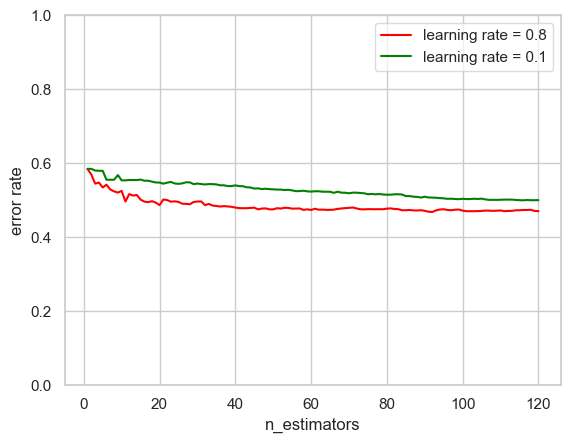

In [174]:
from sklearn.metrics import zero_one_loss

n_estimators = 120

estimatorCart = DecisionTreeClassifier(max_depth=1)
dt_stump1 = AdaBoostClassifier(base_estimator=estimatorCart, n_estimators=n_estimators, learning_rate=0.8)
dt_stump2 = AdaBoostClassifier(base_estimator=estimatorCart, n_estimators=n_estimators, learning_rate=0.1)
dt_stump1.fit(x_train, y_train)
dt_stump_err1 = 1.0 - dt_stump1.score(x_test, y_test)
#
dt_stump2.fit(x_train, y_train)
dt_stump_err2 = 1.0 - dt_stump2.score(x_test, y_test)

############
test_errors1 = []
# 每迭代一次，得到一个测试结果
ada_discrete_err1 = np.zeros((n_estimators,))
ada_discrete_err2 = np.zeros((n_estimators,))
for i, ypred in enumerate(dt_stump1.staged_predict(x_test)):
    ada_discrete_err1[i] = zero_one_loss(ypred, y_test)

for i, ypred in enumerate(dt_stump2.staged_predict(x_test)):
    ada_discrete_err2[i] = zero_one_loss(ypred, y_test)

# 画出迭代次数与准确率的关系
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err1, label='learning rate = 0.8', color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err2, label='learning rate = 0.1', color='green')
ax.set_ylim((0.0, 1))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')
leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)
plt.show()

# 针对当前数据，学习率小，错误率低

In [176]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=24), n_estimators=120, learning_rate=0.1)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.5267284390591589
train f1_score: 0.679695419518778
test f1_score: 0.5588569077544258


## Feature engineering

Text(0.5, 1.0, 'Correlation analysis for all sites')

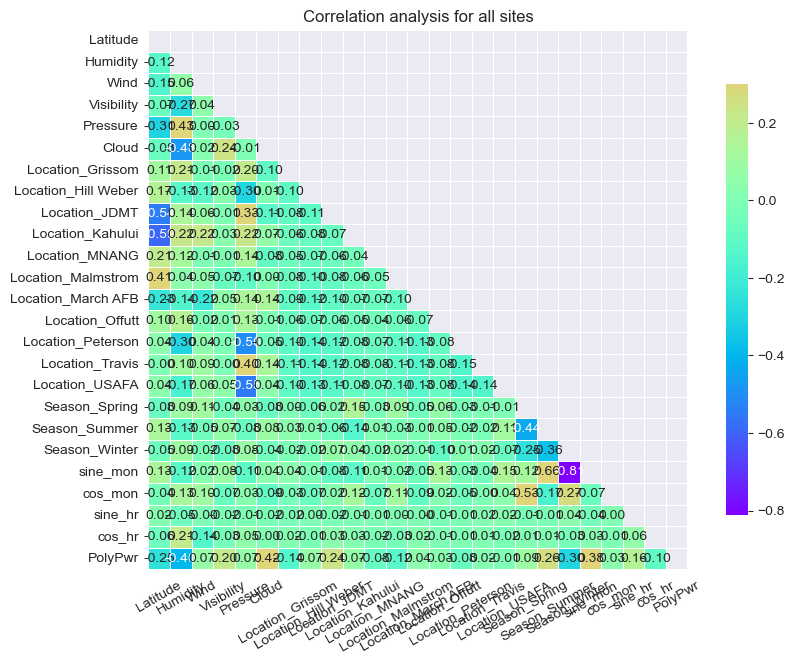

In [15]:
# Correlation analysis
df_corr = df_with_loc_season_en[['Latitude', 'Humidity', 'Wind',
                                 'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
                                 'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                                 'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                                 'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                                 'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                                 'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr', 'PolyPwr']].corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))

f1, ax1 = plt.subplots(figsize=(10, 7))
sns.heatmap(df_corr, ax=ax1, mask=mask, cmap='rainbow', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
ax1.tick_params(axis='x', rotation=30)
plt.title('Correlation analysis for all sites')